In [ ]:
!python3 -m pip install matplotlib python-kraken-sdk pandas

In [4]:
import matplotlib.pyplot as plt
from kraken.spot import Market
import pandas as pd

___
# Load historical XBT/USD 4h ohlc data for the past month

In [7]:
df = pd.DataFrame(
    Market().get_ohlc(pair='XBTUSD', interval=240, since=1676674800)['XXBTZUSD'], # 4h candles since Fri Feb 17 2023 23:00:00 GMT+0000 (i.e. 720 times 4h candles)
    columns=['time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count']
).astype(float)
df['time'] = pd.to_datetime(df['time'], unit='s')
df = df.set_index('time')
df = df.sort_values(by='time')
df

,open,high,low,close,vwap,volume,count
time,,,,,,,
2023-02-18 08:00:00,24523.6,24599.9,24454.4,24529.1,24523.1,120.856970,3051.0
2023-02-18 12:00:00,24528.4,24732.7,24502.6,24669.5,24646.8,256.344992,5074.0
2023-02-18 16:00:00,24676.1,24872.7,24584.5,24617.1,24714.6,354.806433,5155.0
2023-02-18 20:00:00,24617.0,24665.0,24537.3,24643.7,24613.2,151.578099,3770.0
2023-02-19 00:00:00,24643.8,24770.5,24642.2,24677.4,24702.0,128.321239,3290.0
...,...,...,...,...,...,...,...
2023-06-17 12:00:00,26498.6,26573.8,26325.5,26401.0,26474.1,356.975161,4998.0
2023-06-17 16:00:00,26401.0,26522.1,26372.5,26466.5,26445.2,252.269447,3829.0
2023-06-17 20:00:00,26466.5,26589.1,26461.1,26511.8,26524.4,184.790598,3460.0


Text(0, 0.5, 'price in Dollar')

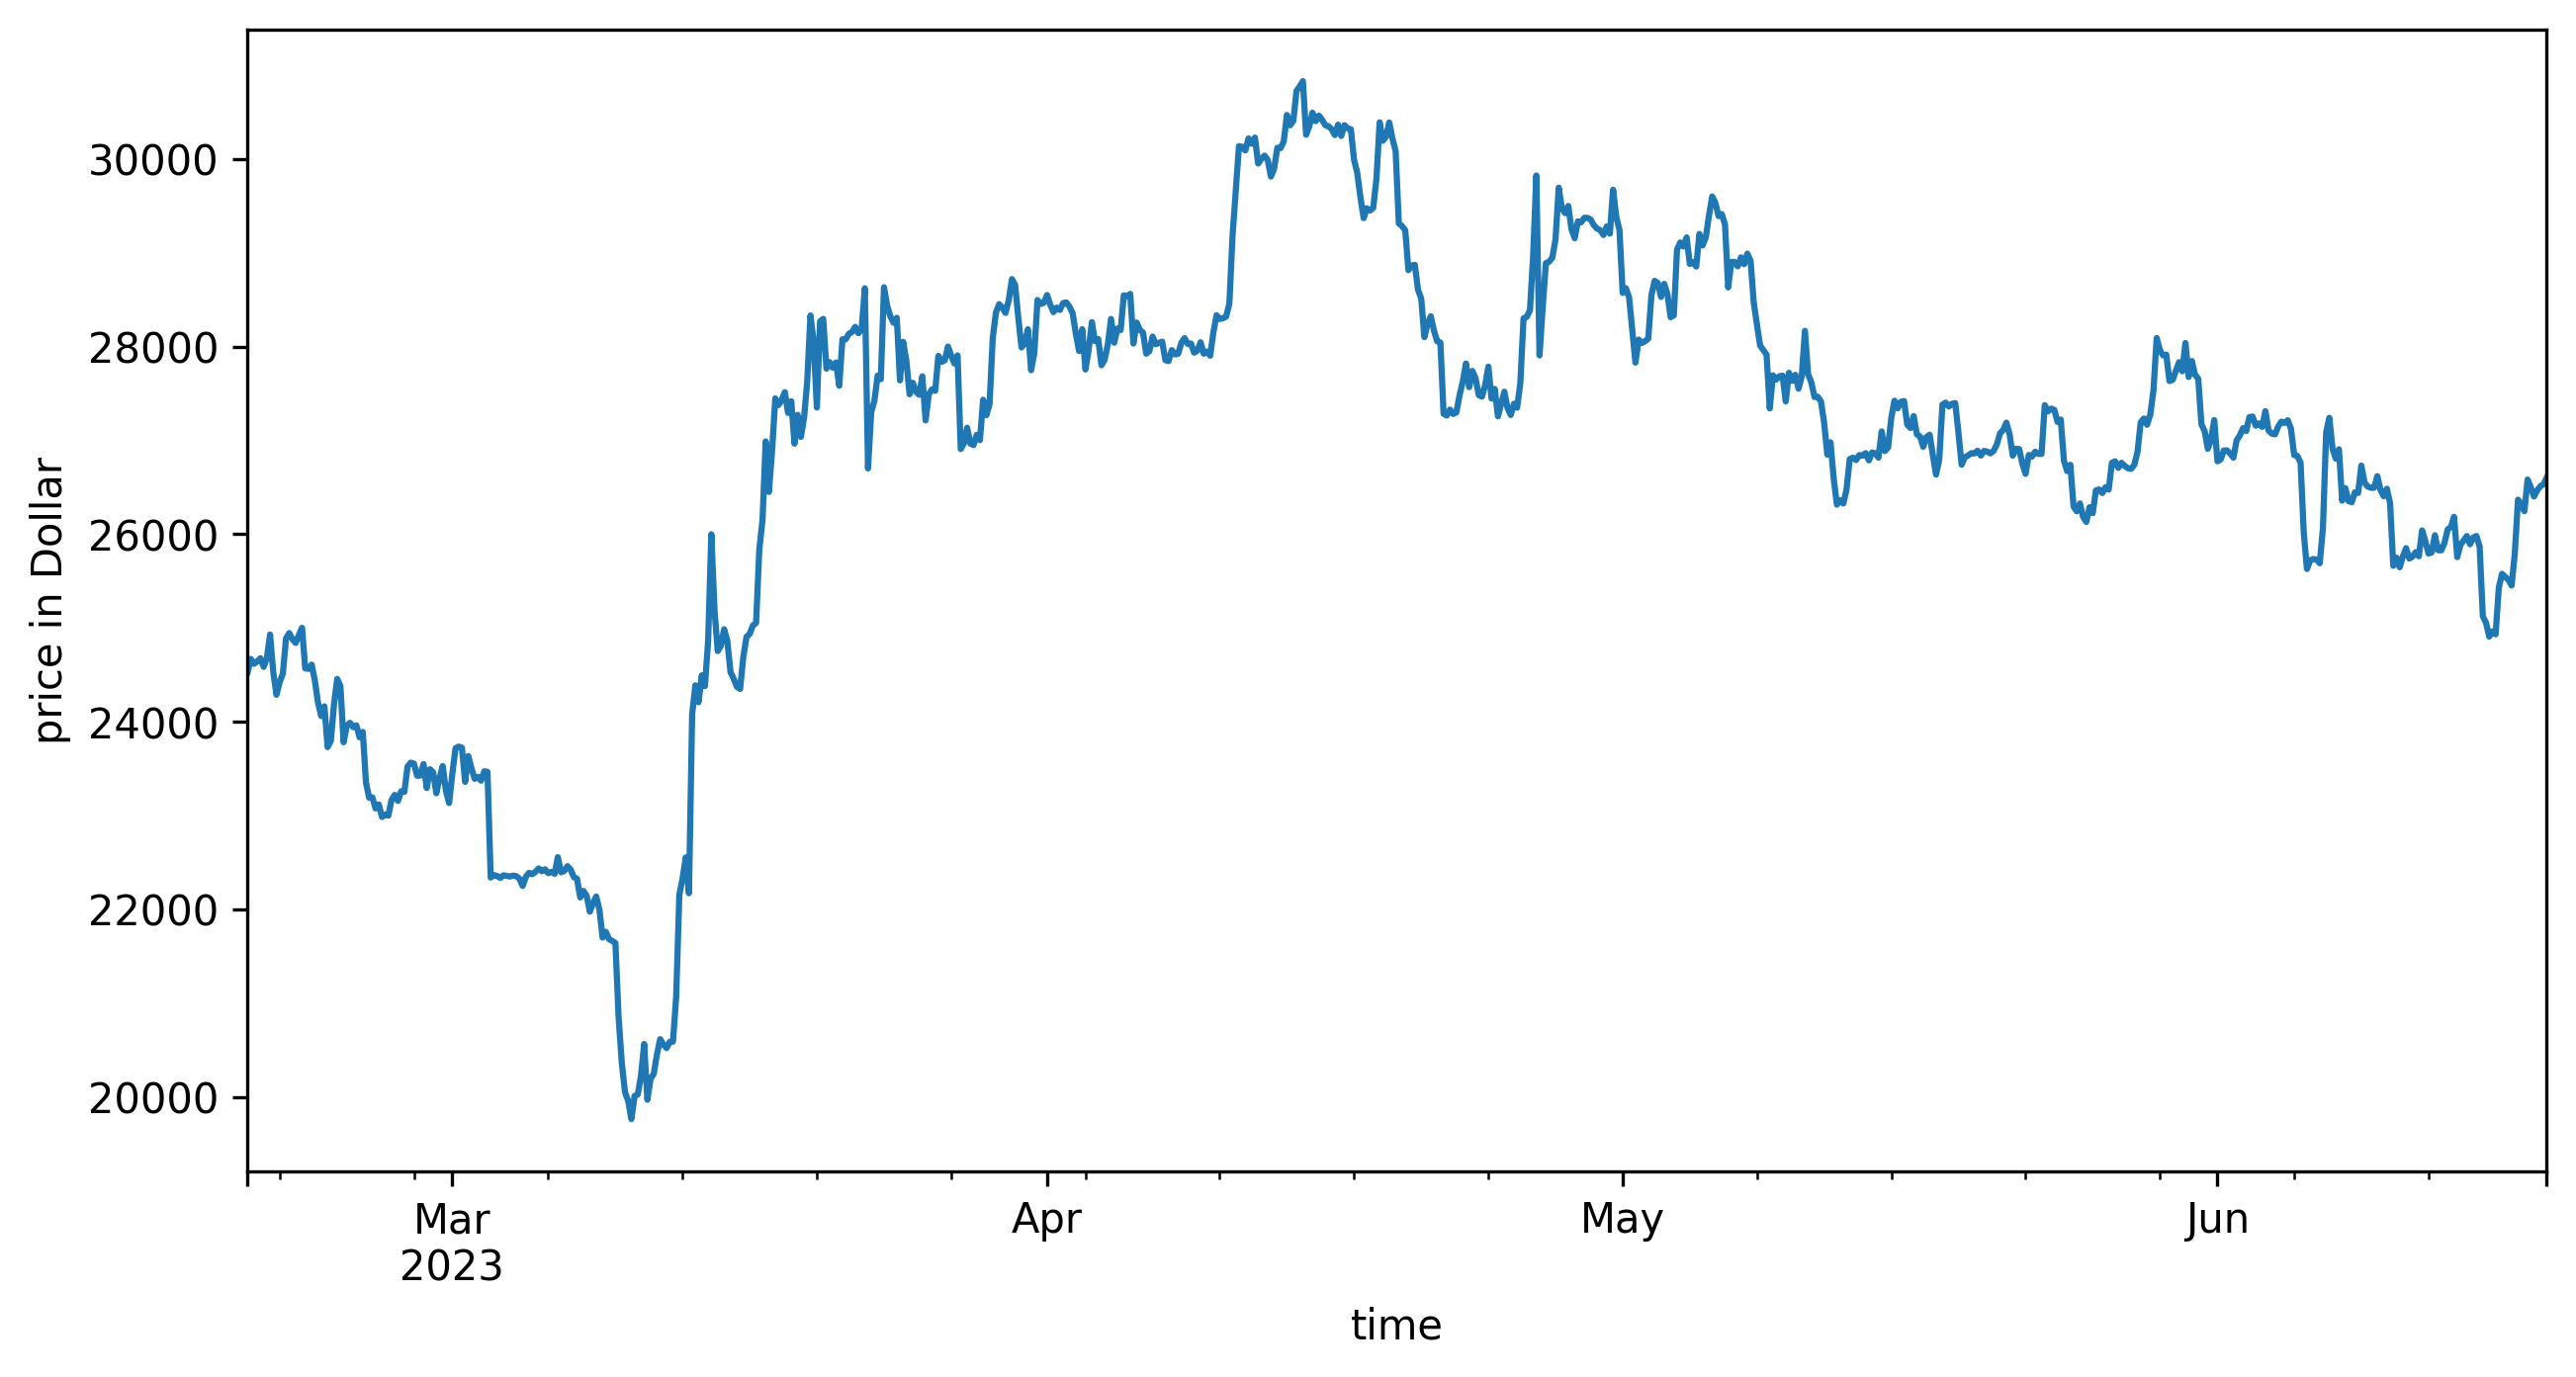

In [8]:
plt.figure(figsize=(10,5), dpi=300)
ax = plt.gca()
df.close.plot(ax=ax)
ax.set_ylabel('price in Dollar')

____
# Test the strategy based on this data

In [9]:
margin = 0.04           # set 4% margin
initial_quote = 200     # how many USD is in your portfolio at the beginning
quotes = initial_quote  # available quote currency
target = 100            # how much value of BTC to hold ($100 worth of BTC)
initial_holdings = 0    # how many BTC is in your portfolio at the beginniing
holdings = initial_holdings
fee = 0.0026            # taker fee without any Tier level
payed_fee = 0
n_trades = 0

for price in df.close:
    actual_value = holdings * price
    if actual_value < target - target * margin:
        to_buy = target - actual_value
        xfee = to_buy * fee
        quotes -= to_buy + xfee
        holdings += (to_buy - xfee) / price
        payed_fee += xfee
        n_trades += 1
    if actual_value > target + target * margin:
        to_sell = abs(target - actual_value)
        xfee = to_sell * fee
        quotes += to_sell - xfee
        holdings -= to_sell / price
        payed_fee += xfee
        n_trades += 1

profit = (quotes + holdings * df.close.iloc[-1]) - (initial_quote)
pprofit = (1 - (quotes + holdings * df.close.iloc[-1]) / (initial_quote)) * -100

print(f'Available USD: {quotes}                                         \
    \nAvailable BTC: {holdings} ~ {holdings * df.close.iloc[-1]} USD    \
    \nPayed fee: {payed_fee} USD                                        \
    \nNumber of trades: {n_trades}                                      \
    \nProfits: {profit} USD ({round(pprofit,2)}%)                       \
    \nPortfolio net worth: {quotes + holdings * df.close.iloc[-1]} USD ({round(pprofit,2)}%)' 
)

Available USD: 107.74739603046771                                             
Available BTC: 0.0038962499551326796 ~ 103.6558338063498 USD        
Payed fee: 0.6781753653188562 USD                                            
Number of trades: 32                                          
Profits: 11.403229836817502 USD (5.7%)                           
Portfolio net worth: 211.4032298368175 USD (5.7%)


As you can see, the bot made 5.7% profit in this market. - But please - try out some more configurations before using this strategy.